**1. Import Modules**

In [2]:
'''
  Import all necessary modules
'''

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam, Adadelta
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed
from sklearn import preprocessing
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**2. Dataset Preparation**

In [4]:
# Import dataset
df = pd.read_csv('/content/gdrive/MyDrive/Thesis/RSE_Module/shuffledDS_2407.csv')
df

,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,408.21,56,5.0,73,121.46,2281
1,328.60,86,1.7,73,9.20,1627
2,356.75,56,7.5,83,8.75,1479
3,246.53,88,6.8,53,63.45,1981
4,176.25,89,7.1,80,39.50,1226
...,...,...,...,...,...,...
2402,170.00,85,3.1,60,48.25,1739
2403,169.75,69,8.1,60,11.75,1196
2404,125.45,59,8.6,73,58.45,1231
2405,434.67,69,0.6,73,1.67,1395


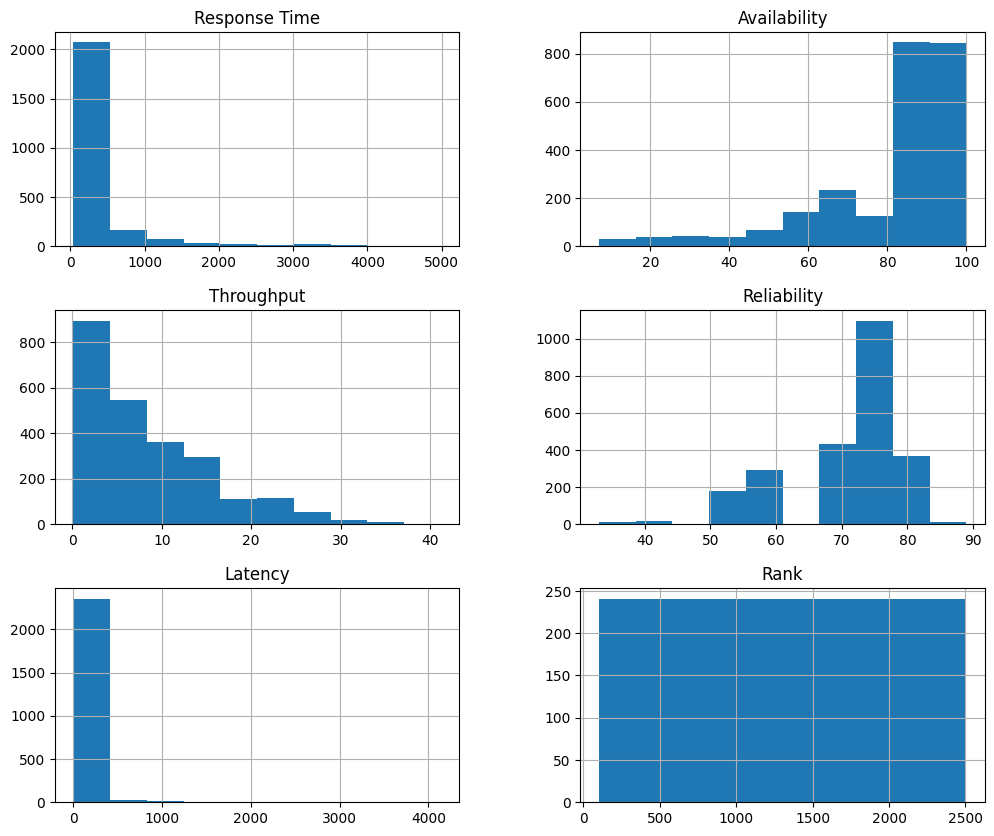

In [5]:
df.hist(figsize = (12,10))
plt.show()

<ipython-input-6-4cb77cfa23f2>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

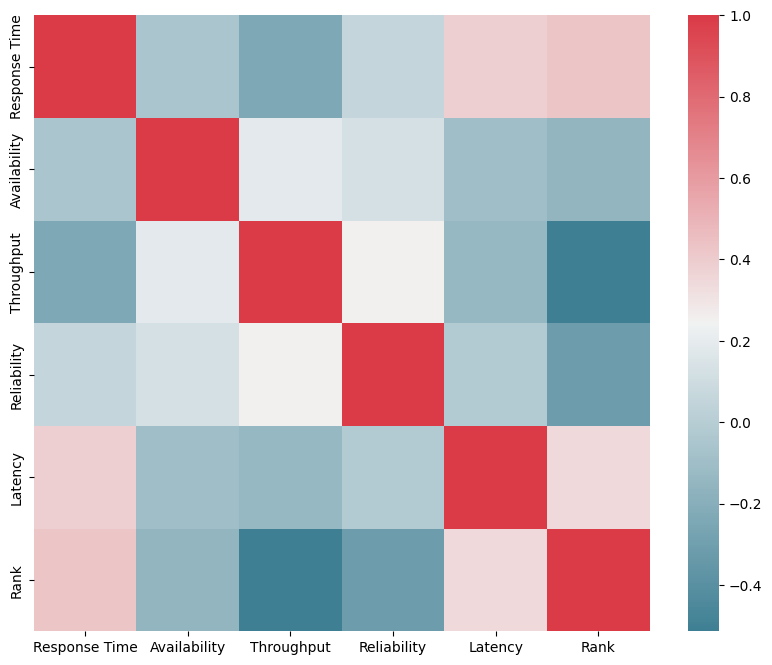

In [6]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<Axes: >

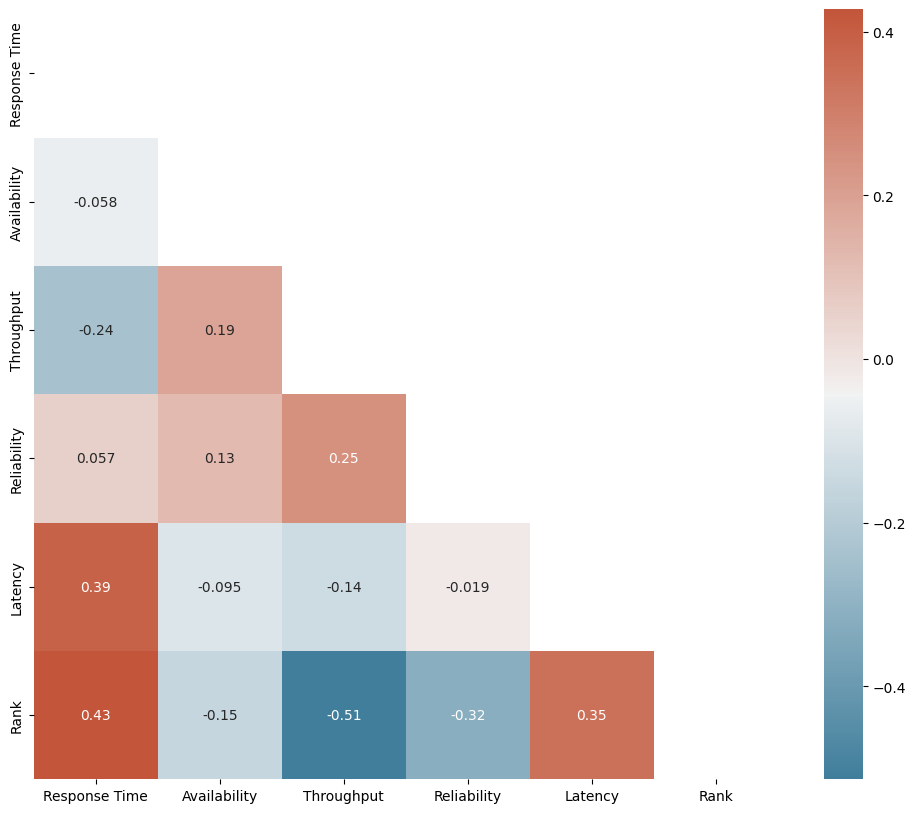

In [7]:
# Correlation between different variables
#
corr = df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [8]:
# Create python dataframe
decisions = pd.DataFrame()
decisions['Response Time'] = df['Response Time']
decisions['Availability'] = df['Availability']
decisions['Throughput'] = df['Throughput']
decisions['Reliability'] = df['Reliability']
decisions['Latency'] = df['Latency']
decisions['Rank'] = df['Rank']
decisions


,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,408.21,56,5.0,73,121.46,2281
1,328.60,86,1.7,73,9.20,1627
2,356.75,56,7.5,83,8.75,1479
3,246.53,88,6.8,53,63.45,1981
4,176.25,89,7.1,80,39.50,1226
...,...,...,...,...,...,...
2402,170.00,85,3.1,60,48.25,1739
2403,169.75,69,8.1,60,11.75,1196
2404,125.45,59,8.6,73,58.45,1231
2405,434.67,69,0.6,73,1.67,1395


In [9]:
'''
 Split dataset to train (70%), test (15%) and validation(15%) sets.
 The top 100 values were removed from the dataset to be split.
      * Reason for removal - We have to check the MAE of the top 100. The data should be unknown to the model to get
        accurate figures.
'''
test_data, temp_data = train_test_split(decisions, test_size=0.3, random_state=42)
train_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_data.shape, test_data.shape,validation_data.shape

((361, 6), (1684, 6), (362, 6))

In [10]:
# Split into input and output values

tmp_train = np.array(train_data)
X_train = tmp_train[:, :-1]
y_train = tmp_train[:, -1]

tmp_test = np.array(test_data)
X_test = tmp_test[:, :-1]
y_test = tmp_test[:, -1]

tmp_val = np.array(validation_data)
X_validation = tmp_val[:, :-1]
y_validation = tmp_val[:, -1]


**3. Model Preparation**

In [11]:
seed(0)
set_random_seed(0)

In [12]:
'''
 This function is used to display the training history of the dataset.
'''
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [13]:
# 1 hidden layer neural network

model = Sequential()
# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal', activation='relu', input_shape=(5,)))
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
#model.add(Dense(64, kernel_initializer='normal',activation='relu'))
#model.add(Dense(32, kernel_initializer='normal',activation='relu'))
#model.add(Dense(16, kernel_initializer='normal',activation='relu'))
#model.add(Dense(8, kernel_initializer='normal',activation='relu'))

model.add(Dense(1))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1536      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34561 (135.00 KB)
Trainable params: 34561 (135.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
'''
Checkpoints are used to save the model at some interval, so the model can be loaded from the saved state to continue training
'''
cp = ModelCheckpoint('model_ann_all/', save_best_only=True)

# Compile model
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001), metrics='mean_absolute_error')


In [16]:
#train model
start_time = time.time()
train_history = model.fit(X_train, y_train, epochs=1500, validation_data=(X_validation, y_validation), callbacks=[cp])

Epoch 1/1500
12/12 [==============================] - 2s 124ms/step - loss: 1178.3116 - mean_absolute_error: 1178.3116 - val_loss: 999.5048 - val_mean_absolute_error: 999.5048
Epoch 2/1500
12/12 [==============================] - 1s 88ms/step - loss: 933.8071 - mean_absolute_error: 933.8071 - val_loss: 781.5541 - val_mean_absolute_error: 781.5541
Epoch 3/1500
12/12 [==============================] - 1s 87ms/step - loss: 791.8384 - mean_absolute_error: 791.8384 - val_loss: 642.7126 - val_mean_absolute_error: 642.7126
Epoch 4/1500
12/12 [==============================] - 1s 92ms/step - loss: 736.2488 - mean_absolute_error: 736.2488 - val_loss: 609.2319 - val_mean_absolute_error: 609.2319
Epoch 5/1500
12/12 [==============================] - 0s 13ms/step - loss: 689.2021 - mean_absolute_error: 689.2021 - val_loss: 613.2336 - val_mean_absolute_error: 613.2336
Epoch 6/1500
12/12 [==============================] - 1s 83ms/step - loss: 654.5041 - mean_absolute_error: 654.5041 - val_loss: 583.

In [17]:
#ephoch = 1500, LR=0.001, 2-Hidden
train_acc = model.evaluate(X_train, y_train, verbose=0)
print('MAE training : {:.3f}'.format(train_acc[1]))
scores = model.evaluate(X_validation, y_validation)
print('MAE validation : {:.3f}'.format(scores[1]))

test_acc = model.evaluate(X_test, y_test)
print('MAE test : {:.3f}'.format(test_acc[1]))

MAE training : 59.355
12/12 [==============================] - 0s 3ms/step - loss: 86.9465 - mean_absolute_error: 86.9465
MAE validation : 86.946
53/53 [==============================] - 0s 2ms/step - loss: 92.8238 - mean_absolute_error: 92.8238
MAE test : 92.824


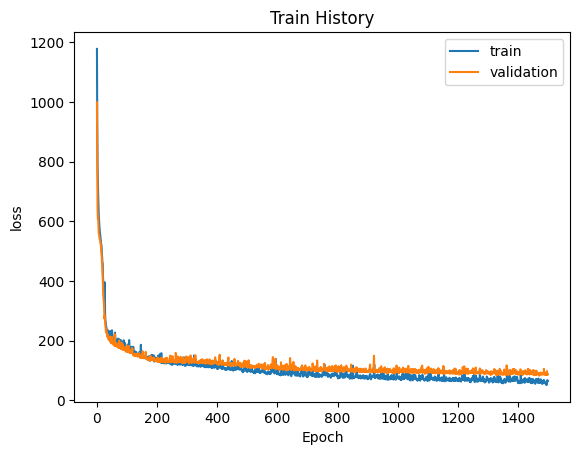

In [18]:
#ephoch = 1500, LR=0.001, 2-Hidden
show_train_history(train_history,'loss','val_loss')

**Results for 500 epochs**

In [19]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train.flatten()})
train_results


12/12 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,1358.092773,1338.0
1,2339.356934,2302.0
2,1568.444702,1547.0
3,269.852173,244.0
4,1744.406616,1562.0
...,...,...
356,2481.882324,2381.0
357,2433.096436,2127.0
358,823.868713,786.0
359,1075.917969,1051.0


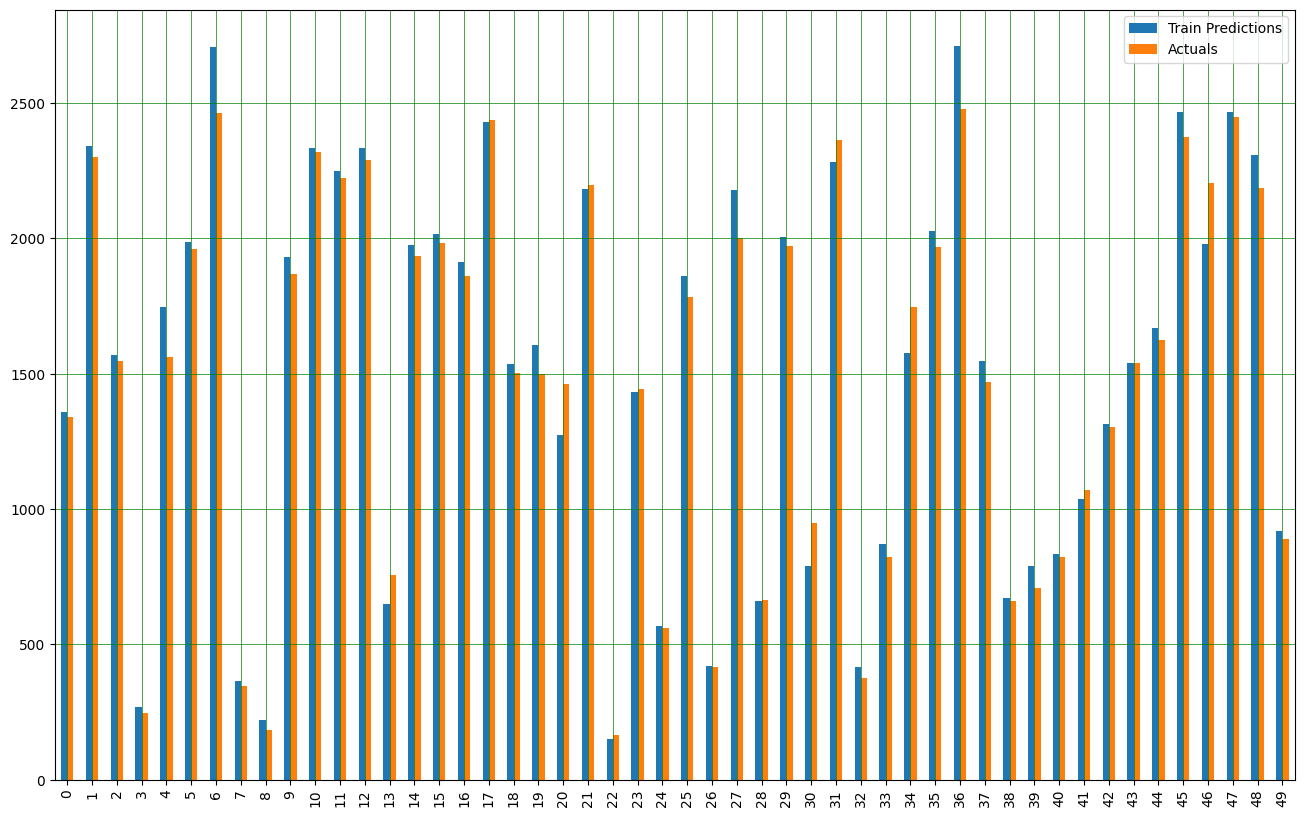

In [20]:
res1 = train_results.head(50)
res1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [21]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

53/53 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,1368.431641,1367.0
1,1036.779663,990.0
2,1652.633667,1537.0
3,848.963745,842.0
4,992.122253,1067.0
...,...,...
1679,864.272400,774.0
1680,2174.745605,2230.0
1681,2239.113281,2227.0
1682,2695.412598,2214.0


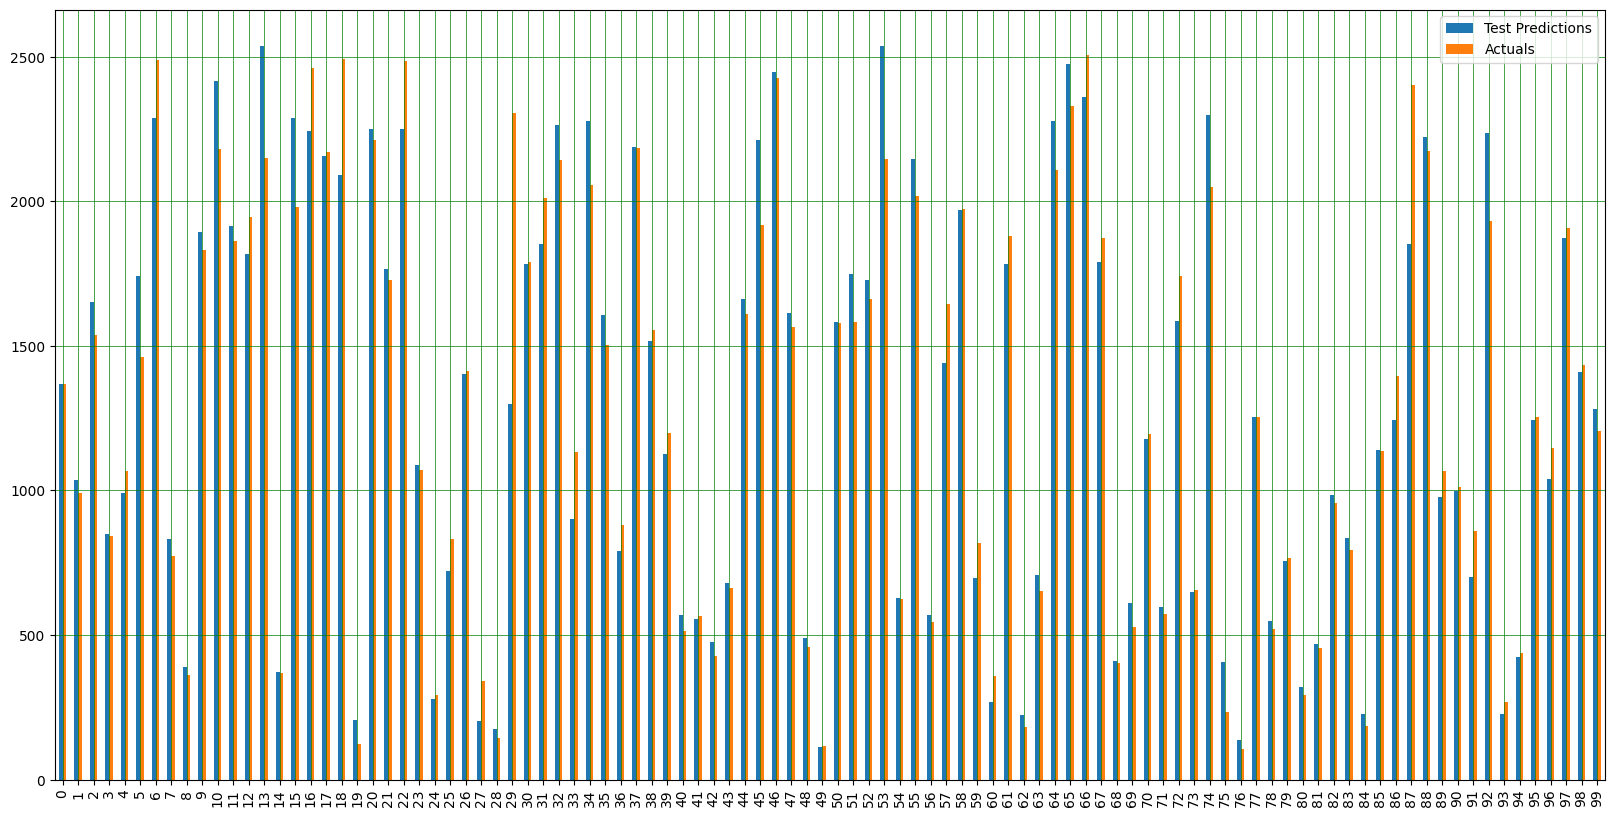

In [22]:

res2 = test_results.head(100)
res2.plot(kind='bar',figsize=(20,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

TOP 100

In [23]:
# Import dataset for Top 100
df_2 = pd.read_csv('/content/gdrive/MyDrive/Thesis/RSE_Module/shuffledTop100.csv')
df_2

,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,124.38,87,15.8,73,0.88,84
1,89.00,83,13.2,73,1.00,54
2,129.33,95,15.9,73,1.00,71
3,38.00,71,21.1,73,2.00,46
4,100.00,94,21.8,73,2.00,45
...,...,...,...,...,...,...
95,107.00,91,36.9,83,3.00,61
96,49.00,72,21.6,78,2.50,72
97,78.00,100,10.0,80,1.00,15
98,65.07,88,16.7,67,1.28,93


In [24]:
# Create python dataframe
decisions_2 = pd.DataFrame()
decisions_2['Response Time'] = df_2['Response Time']
decisions_2['Availability'] = df_2['Availability']
decisions_2['Throughput'] = df_2['Throughput']
decisions_2['Reliability'] = df_2['Reliability']
decisions_2['Latency'] = df_2['Latency']
decisions_2['Rank'] = df_2['Rank']

In [25]:
test_data_top = decisions_2[0:100]
test_data_top.shape

(100, 6)

In [26]:
tmp_top = np.array(test_data_top)
X_test_top = tmp_top[:, :-1]
y_test_top = tmp_top[:, -1]
X_test_top.shape, y_test_top.shape

((100, 5), (100,))

In [27]:
test_acc_top = model.evaluate(X_test_top, y_test_top)
print('MAE test top : {:.3f}'.format(test_acc_top[1]))

4/4 [==============================] - 0s 6ms/step - loss: 29.6477 - mean_absolute_error: 29.6477
MAE test top : 29.648


In [28]:
test_predictions_top = model.predict(X_test_top).flatten()
end_time = time.time()
test_results_top = pd.DataFrame(data={'Test Predictions':test_predictions_top, 'Actuals':y_test_top.flatten()})
test_results_top.to_csv(r'/content/gdrive/MyDrive/Thesis/RSE_Module/DL_Algorithm/ANN/Predictions_Test_Top_Results_ANN.csv')
test_results_top

4/4 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,141.231430,84.0
1,96.688011,54.0
2,129.479965,71.0
3,10.772449,46.0
4,84.663094,45.0
...,...,...
95,106.447136,61.0
96,33.598057,72.0
97,35.767654,15.0
98,34.106056,93.0


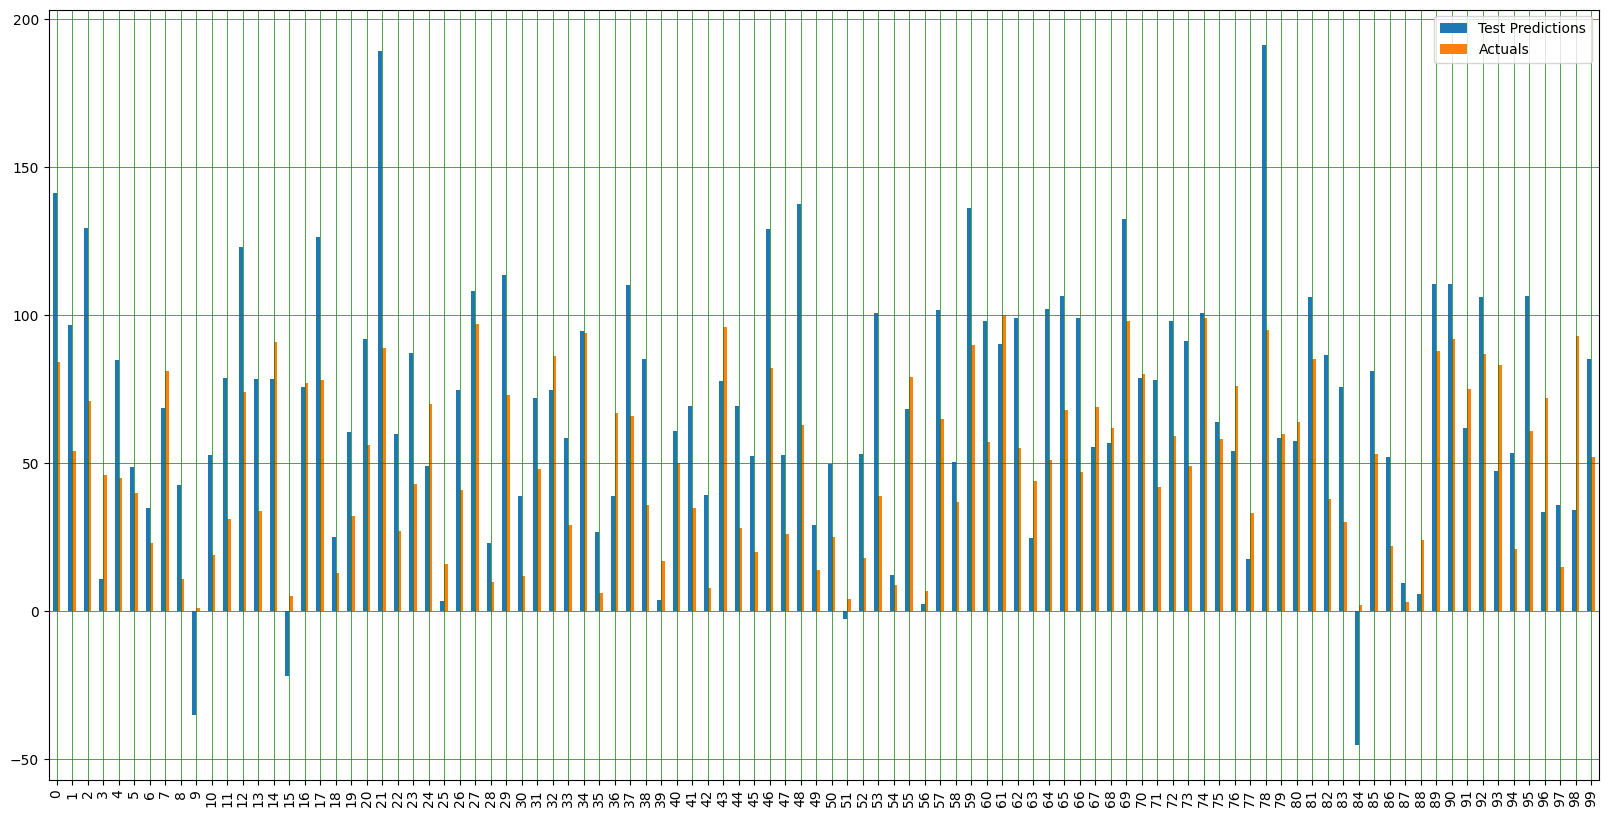

In [29]:
res3 = test_results_top.head(100)
res3.plot(kind='bar',figsize=(20,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [30]:
elapsed_time = end_time - start_time

elapsed_time

326.8386924266815